<a href="https://colab.research.google.com/github/randamzz/energy-contol-with-IoT-and-ML/blob/main/Predict_consumption.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Prédiction de la Consommation Mensuelle d'Électricité à l'aide de Modèles LSTM**

**1. Chargement et Préparation des Données**

In [1]:
import pandas as pd
df = pd.read_csv('/content/consommation-quotidienne-brute.csv', sep=';')
df.head()

,Date - Heure,Date,Heure,Consommation brute gaz (MW PCS 0°C) - GRTgaz,Statut - GRTgaz,Consommation brute gaz (MW PCS 0°C) - Teréga,Statut - Teréga,Consommation brute gaz totale (MW PCS 0°C),Consommation brute électricité (MW) - RTE,Statut - RTE,Consommation brute totale (MW)
0,2024-10-31T23:30:00+01:00,31/10/2024,23:30,NaN,NaN,NaN,NaN,NaN,47110,Consolidé,NaN
1,2024-10-31T23:00:00+01:00,31/10/2024,23:00,30998.0,Redressé,1734.0,Définitif,32732.0,47753,Consolidé,80485.0
2,2024-10-31T22:30:00+01:00,31/10/2024,22:30,NaN,NaN,NaN,NaN,NaN,48552,Consolidé,NaN
3,2024-10-31T22:00:00+01:00,31/10/2024,22:00,33674.0,Redressé,1867.0,Définitif,35541.0,47498,Consolidé,83039.0
4,2024-10-31T21:30:00+01:00,31/10/2024,21:30,NaN,NaN,NaN,NaN,NaN,46852,Consolidé,NaN


In [2]:
df = df[['Date', 'Heure', 'Consommation brute électricité (MW) - RTE', 'Statut - RTE']]
df.head()

,Date,Heure,Consommation brute électricité (MW) - RTE,Statut - RTE
0,31/10/2024,23:30,47110,Consolidé
1,31/10/2024,23:00,47753,Consolidé
2,31/10/2024,22:30,48552,Consolidé
3,31/10/2024,22:00,47498,Consolidé
4,31/10/2024,21:30,46852,Consolidé


**2. Analyse Exploratoire des Données (EDA)**

**2.1. Structure et Qualité des Données**

*Comprendre la Structure des Données*

In [3]:
print(df.shape)
print(df.describe())



(225024, 4)
       Consommation brute électricité (MW) - RTE
count                              225024.000000
mean                                53068.408459
std                                 11843.449053
min                                 28738.000000
25%                                 44108.000000
50%                                 51248.000000
75%                                 60896.000000
max                                101866.000000


*Nettoyage des Données*

In [4]:
#Détection des Valeurs Manquantes
print("Les valeurs manquantes")
print(df.isnull().sum())

#Détection des Redondances
print("Les redondances")
print(df.duplicated().sum())
df = df.drop_duplicates()



Les valeurs manquantes
Date                                         0
Heure                                        0
Consommation brute électricité (MW) - RTE    0
Statut - RTE                                 0
dtype: int64
Les redondances
0


 **2.2. Analyse de la Distribution des Données**



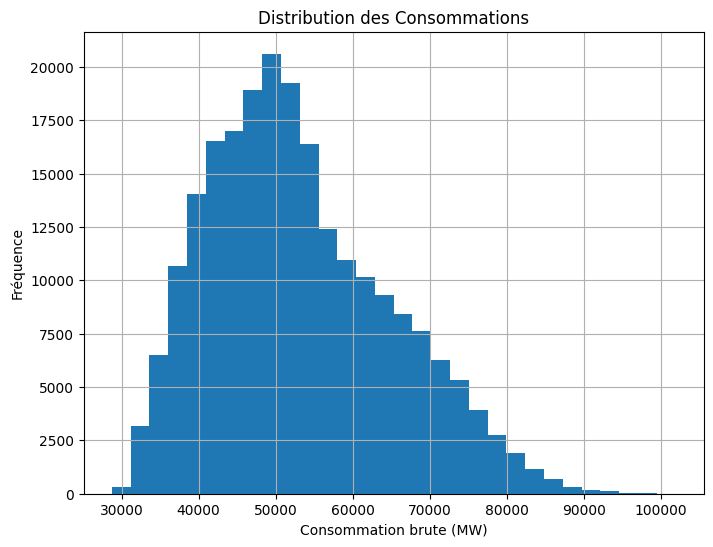

In [5]:
import matplotlib.pyplot as plt
df['Consommation brute électricité (MW) - RTE'].hist(bins=30, figsize=(8, 6))
plt.title("Distribution des Consommations")
plt.xlabel("Consommation brute (MW)")
plt.ylabel("Fréquence") # Indique le nombre d'observations (lignes dans votre dataset) qui tombent dans chaque intervalle.
plt.show()


objectif de se histogramme :

*   Quelle est la plage de consommation brute la plus fréquente ?
*  Y a-t-il des valeurs de consommation très élevées ou très faibles qui semblent inhabituelles ?
*  Les données sont-elles symétriques ou présentent-elles un biais (par exemple, une tendance vers de faibles consommations) ?



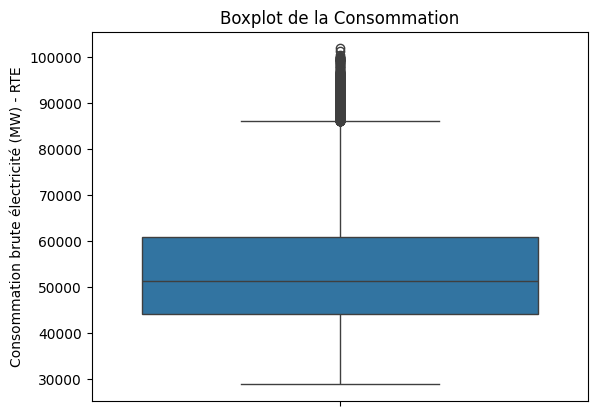

In [6]:
import seaborn as sns
sns.boxplot(data=df['Consommation brute électricité (MW) - RTE'])
plt.title("Boxplot de la Consommation")
plt.show()


**2.3. Visualisation des Tendances Temporelles**

<ipython-input-7-7cf25410f6d4>:3: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Année'] = pd.to_datetime(df['Date']).dt.year


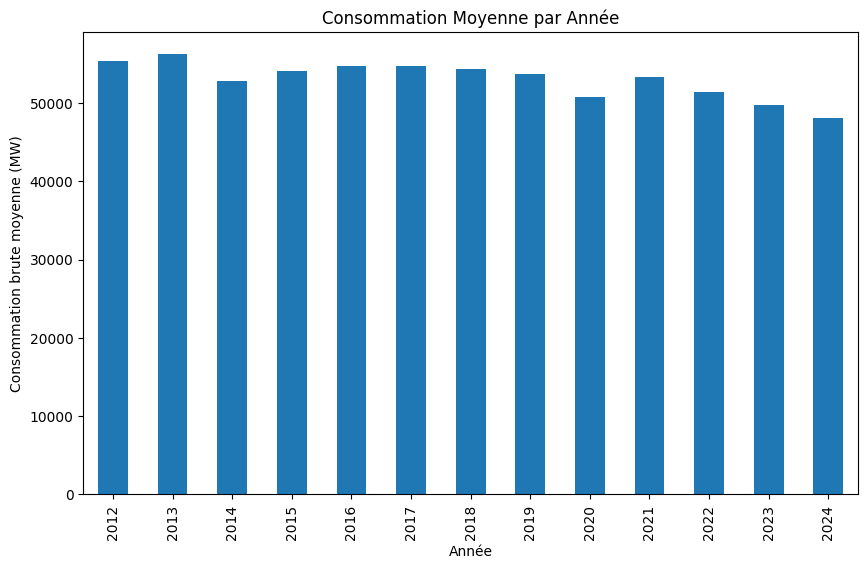

In [7]:
#Consommation Moyenne par Année

df['Année'] = pd.to_datetime(df['Date']).dt.year
consommation_par_annee = df.groupby('Année')['Consommation brute électricité (MW) - RTE'].mean()
consommation_par_annee.plot(kind='bar', figsize=(10, 6))
plt.title("Consommation Moyenne par Année")
plt.ylabel("Consommation brute moyenne (MW)")
plt.xlabel("Année")
plt.show()


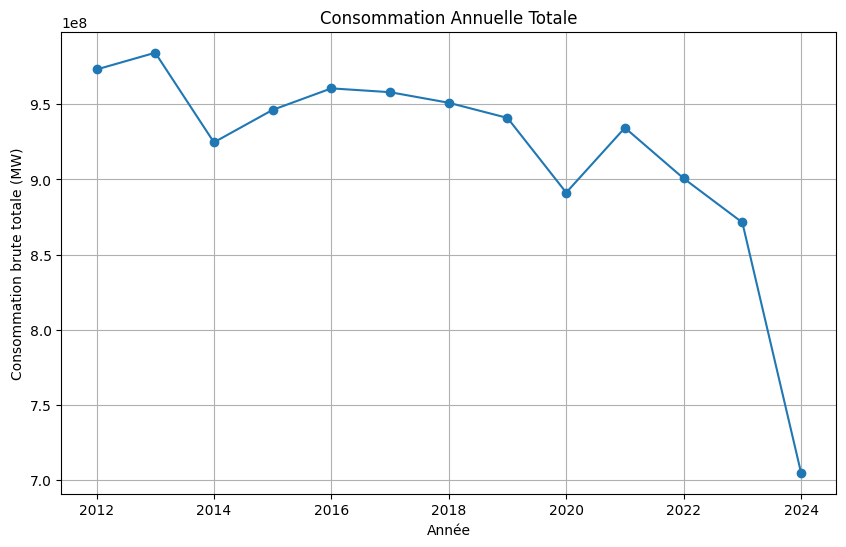

In [8]:
#Consommation Annuelle Totale

consommation_totale_annuelle = df.groupby('Année')['Consommation brute électricité (MW) - RTE'].sum()
consommation_totale_annuelle.plot(kind='line', marker='o', figsize=(10, 6))
plt.title("Consommation Annuelle Totale")
plt.ylabel("Consommation brute totale (MW)")
plt.xlabel("Année")
plt.grid()
plt.show()


<ipython-input-9-ff99d4726d8b>:3: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Mois'] = pd.to_datetime(df['Date']).dt.month


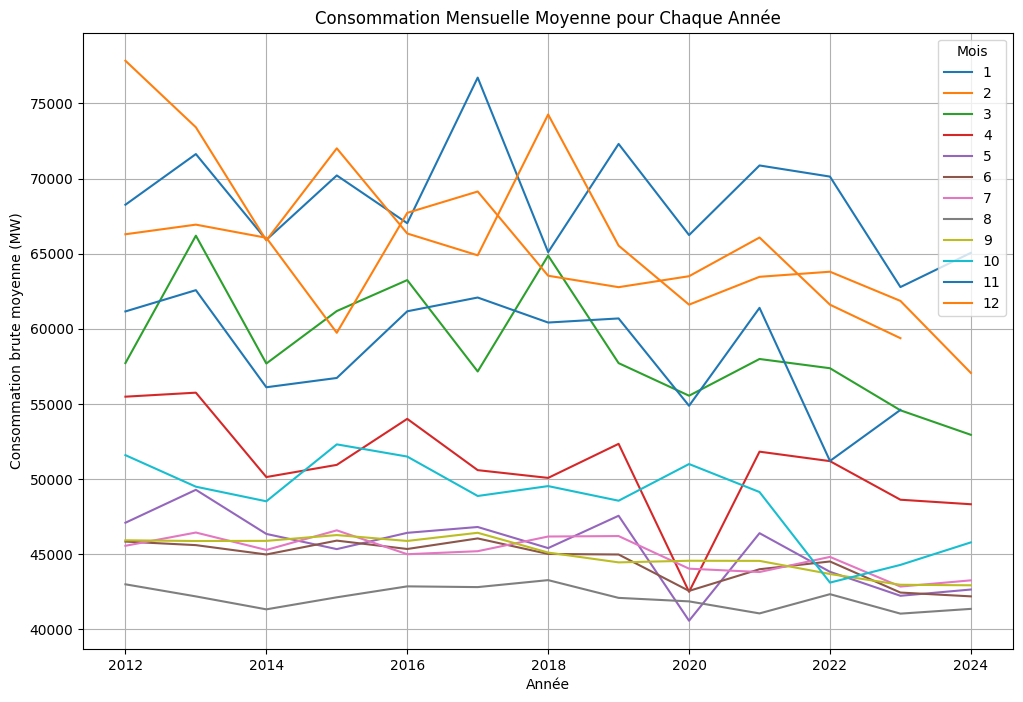

In [9]:
#Consommation Mensuelle pour Chaque Année

df['Mois'] = pd.to_datetime(df['Date']).dt.month
consommation_mensuelle = df.groupby(['Année', 'Mois'])['Consommation brute électricité (MW) - RTE'].mean().unstack()
consommation_mensuelle.plot(kind='line', figsize=(12, 8))
plt.title("Consommation Mensuelle Moyenne pour Chaque Année")
plt.ylabel("Consommation brute moyenne (MW)")
plt.xlabel("Année")
plt.legend(title="Mois")
plt.grid()
plt.show()


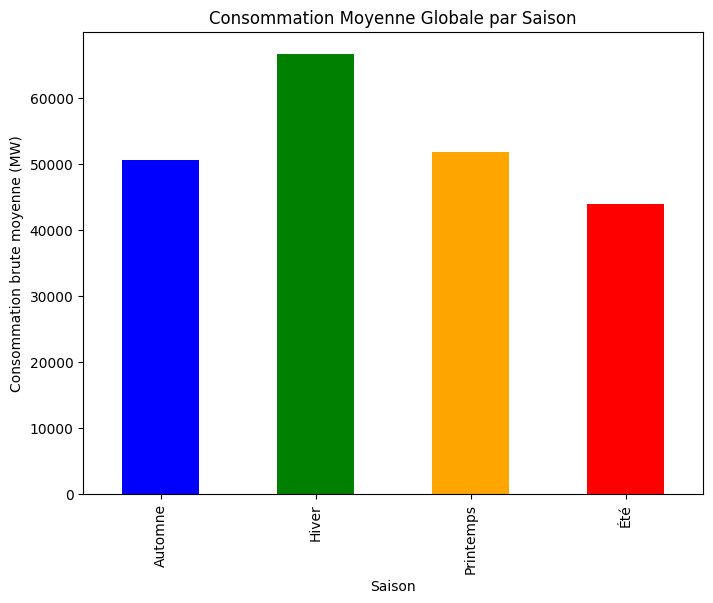

In [10]:
#Analyse Saisonnière

def assign_season(month):
    if month in [12, 1, 2]:
        return 'Hiver'
    elif month in [3, 4, 5]:
        return 'Printemps'
    elif month in [6, 7, 8]:
        return 'Été'
    else:
        return 'Automne'

df['Saison'] = df['Mois'].apply(assign_season)
consommation_par_saison = df.groupby('Saison')['Consommation brute électricité (MW) - RTE'].mean()
consommation_par_saison.plot(kind='bar', figsize=(8, 6), color=['blue', 'green', 'orange', 'red'])
plt.title("Consommation Moyenne Globale par Saison")
plt.ylabel("Consommation brute moyenne (MW)")
plt.xlabel("Saison")
plt.show()


<ipython-input-11-b12033194271>:3: UserWarning: Parsing dates in %d/%m/%Y format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['Jour'] = pd.to_datetime(df['Date']).dt.day_name()


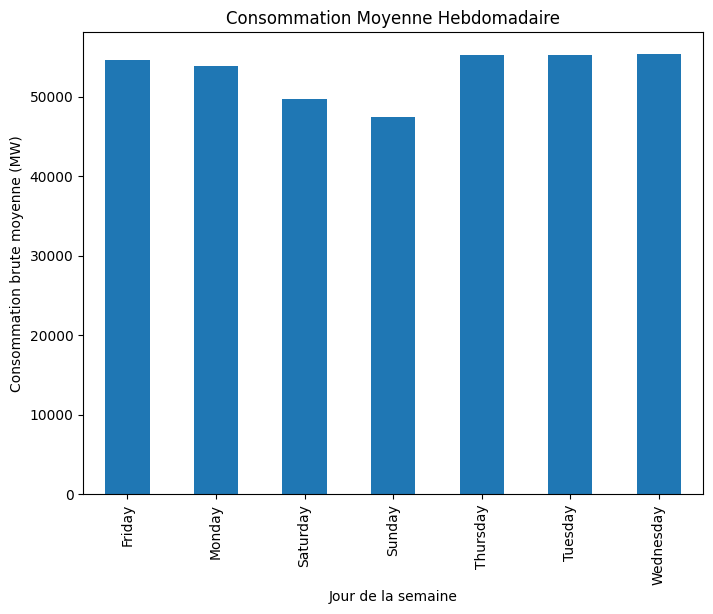

In [11]:
#Consommation Hebdomadaire et Heures de la Journée

df['Jour'] = pd.to_datetime(df['Date']).dt.day_name()
consommation_par_jour = df.groupby('Jour')['Consommation brute électricité (MW) - RTE'].mean()
consommation_par_jour.plot(kind='bar', figsize=(8, 6))
plt.title("Consommation Moyenne Hebdomadaire")
plt.ylabel("Consommation brute moyenne (MW)")
plt.xlabel("Jour de la semaine")
plt.show()


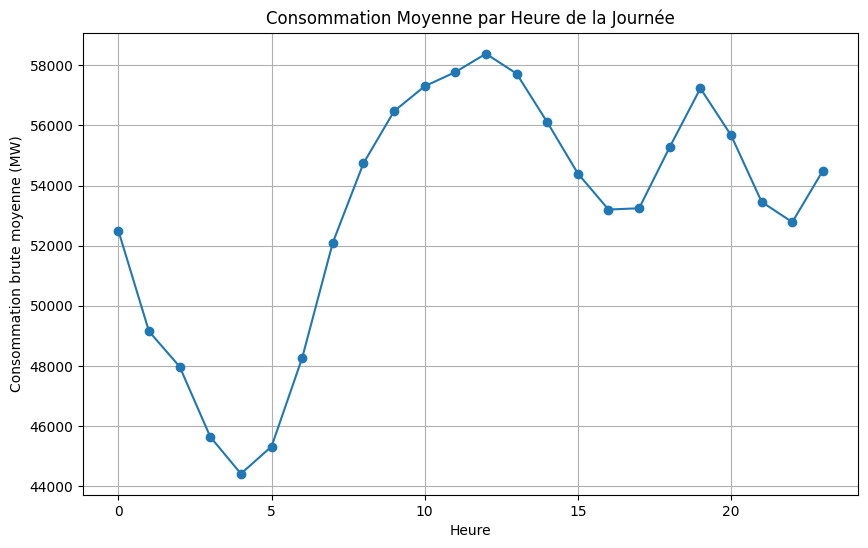

In [12]:
#Consommation Moyenne par Heure

df['Heure'] = pd.to_datetime(df['Heure'], format='%H:%M').dt.hour
consommation_par_heure = df.groupby('Heure')['Consommation brute électricité (MW) - RTE'].mean()
consommation_par_heure.plot(kind='line', figsize=(10, 6), marker='o')
plt.title("Consommation Moyenne par Heure de la Journée")
plt.ylabel("Consommation brute moyenne (MW)")
plt.xlabel("Heure")
plt.grid()
plt.show()


**3. Prétraitement des données**

*3.1. Transformation des variables temporelles*

In [13]:

# Convertir Date et Heure en datetime
df['datetime'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Heure'].astype(str), errors='coerce')
# Créer des colonnes temporelles dérivées
#deja fait
df.head()



<ipython-input-13-11fdb5d283f6>:2: UserWarning: Parsing dates in %d/%m/%Y %H format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df['datetime'] = pd.to_datetime(df['Date'].astype(str) + ' ' + df['Heure'].astype(str), errors='coerce')


,Date,Heure,Consommation brute électricité (MW) - RTE,Statut - RTE,Année,Mois,Saison,Jour,datetime
0,31/10/2024,23,47110,Consolidé,2024,10,Automne,Thursday,2024-10-31 23:00:00
1,31/10/2024,23,47753,Consolidé,2024,10,Automne,Thursday,2024-10-31 23:00:00
2,31/10/2024,22,48552,Consolidé,2024,10,Automne,Thursday,2024-10-31 22:00:00
3,31/10/2024,22,47498,Consolidé,2024,10,Automne,Thursday,2024-10-31 22:00:00
4,31/10/2024,21,46852,Consolidé,2024,10,Automne,Thursday,2024-10-31 21:00:00


*3.2. Encodage des variables catégoriques*

pour cette phase on a utuliser LabelEncoder : Il mappe chaque catégorie à une valeur numérique unique.


In [14]:
from sklearn.preprocessing import LabelEncoder

# Encodage de 'Statut - RTE'
label_encoder_status = LabelEncoder()
df['Statut - RTE_encoded'] = label_encoder_status.fit_transform(df['Statut - RTE'])

# Encodage des saisons
label_encoder_season = LabelEncoder()
df['season_encoded'] = label_encoder_season.fit_transform(df['Saison'])

# Affichage des premières lignes après l'encodage
print(df[['Statut - RTE', 'Statut - RTE_encoded', 'Saison', 'season_encoded']].tail())


       Statut - RTE  Statut - RTE_encoded Saison  season_encoded
225019    Définitif                     1  Hiver               1
225020    Définitif                     1  Hiver               1
225021    Définitif                     1  Hiver               1
225022    Définitif                     1  Hiver               1
225023    Définitif                     1  Hiver               1


*3.3. Normalisation/Standardisation*

* Normalisation : Utilisée pour réduire toutes les valeurs entre 0 et 1, adaptée pour les réseaux neuronaux (comme LSTM).
* Standardisation : Utilisée pour centrer les données autour de 0 et réduire leur dispersion à

In [15]:
from sklearn.preprocessing import MinMaxScaler

# Initialiser le scaler
scaler = MinMaxScaler()

# Appliquer la normalisation uniquement sur la consommation brute
df['Consommation brute électricité (MW)'] = scaler.fit_transform(df[['Consommation brute électricité (MW) - RTE']])

df['Consommation brute électricité (MW)'].head()


,Consommation brute électricité (MW)
0,0.251231
1,0.260024
2,0.270950
3,0.256536
4,0.247703


*3.4. Création de séquences temporelles*

Il permet de :


*   Capturer les relations entre les instants passés et futurs
*   Préserver l'ordre temporel
* Préparation pour l'entrée du modèle ([samples, timesteps, features] )



In [16]:
import numpy as np

# Fonction pour créer des séquences temporelles
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(len(data) - n_steps):
        X.append(data[i:i+n_steps])
        y.append(data[i+n_steps])
    return np.array(X), np.array(y)

# Nombre de pas de temps (30 heures)
n_steps = 30

# Créer des séquences
data = df['Consommation brute électricité (MW)'].values
X, y = create_sequences(data, n_steps)

print("Shape of X:", X.shape)
print("Shape of y:", y.shape)


Shape of X: (224994, 30)
Shape of y: (224994,)


*3.5. Division des données (Train/Test Split)*

In [17]:
from sklearn.model_selection import train_test_split

# Division des données en ensemble d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)


X_train shape: (179995, 30)
X_test shape: (44999, 30)


*3.6. Conversion en Tensors*

In [18]:
import tensorflow as tf

# Conversion des données en tensors
X_train = tf.convert_to_tensor(X_train, dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train, dtype=tf.float32)
X_test = tf.convert_to_tensor(X_test, dtype=tf.float32)
y_test = tf.convert_to_tensor(y_test, dtype=tf.float32)

print("Tensors converted successfully!")


Tensors converted successfully!


**4. construire et entraîner le modèle LSTM**

In [31]:
# Vérification de la forme initiale des données
print("Initial shape of X_train:", X_train.shape)
print("Initial shape of y_train:", y_train.shape)


# Reshaper les données d'entrée pour avoir la forme (samples, time_steps, features)
X_train = tf.reshape(X_train, (X_train.shape[0], 30, 1))  # 30 heures, 1 caractéristique par heure
X_test = tf.reshape(X_test, (X_test.shape[0], 30, 1))    # Idem pour les données de test

# Vérification de la forme des données après reshape
print("Reshaped X_train shape:", X_train.shape)
print("Reshaped X_test shape:", X_test.shape)




Initial shape of X_train: (179995, 1, 30)
Initial shape of y_train: (179995,)
Reshaped X_train shape: (179995, 30, 1)
Reshaped X_test shape: (44999, 30, 1)


*4.1.  Construction du modèle LSTM*

In [19]:
X_train_np = X_train.numpy()

import tensorflow as tf

# Reshaper les données avec TensorFlow
X_train = tf.reshape(X_train, (X_train.shape[0], 1, X_train.shape[1]))

# Vérification de la forme
print(X_train.shape)




(179995, 1, 30)


In [20]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Construction du modèle LSTM
model = Sequential()

# la couche LSTM
model.add(LSTM(units=50, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))

# couche Dropout pour éviter l'overfitting
model.add(Dropout(0.2))

# Couche de sortie
model.add(Dense(units=1))

# Résumé du modèle
model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 50)                  │          16,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 16,251 (63.48 KB)

 Trainable params: 16,251 (63.48 KB)

 Non-trainable params: 0 (0.00 B)

*4.2. Compilation du modèle*

In [35]:
# Compilation du modèle
model.compile(optimizer='adam', loss='mean_squared_error')




*4.3.  Entraînement du modèle*

In [36]:
X_train_small = X_train[:100]
y_train_small = y_train[:100]

# Essayez de former le modèle avec un sous-ensemble des données
history = model.fit(X_train_small, y_train_small, epochs=20, batch_size=32, validation_data=(X_test[:100], y_test[:100]))


Epoch 1/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 115ms/step - loss: 0.0742 - val_loss: 0.0527
Epoch 2/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 0.0586 - val_loss: 0.0399
Epoch 3/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0410 - val_loss: 0.0290
Epoch 4/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - loss: 0.0296 - val_loss: 0.0199
Epoch 5/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0216 - val_loss: 0.0114
Epoch 6/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0120 - val_loss: 0.0054
Epoch 7/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0047 - val_loss: 0.0046
Epoch 8/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 0.0062 - val_loss: 0.0057
Epoch 9/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 0.0093 - val_loss: 0.0042
Epoch 10/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - loss: 0.0048 - val_loss: 0.0040
Epoch 11/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 0.0047 - val_loss: 0.0042
Epoch 12/20
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step - loss: 0.0055 - val_loss: 0.0040


In [37]:
# Mise à jour du modèle avec return_sequences=True
model = Sequential()
model.add(LSTM(units=50, activation='relu', input_shape=(30, 1), return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 50)                  │          10,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              51 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 10,451 (40.82 KB)

 Trainable params: 10,451 (40.82 KB)

 Non-trainable params: 0 (0.00 B)

In [39]:
print(f"Shape of X_train before fitting: {X_train.shape}")
print(f"Shape of y_train before fitting: {y_train.shape}")

# Lancer l'entraînement
# Compiler le modèle
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Lancer l'entraînement
history = model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_test, y_test))


Shape of X_train before fitting: (179995, 30, 1)
Shape of y_train before fitting: (179995,)
Epoch 1/20
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 206s 18ms/step - loss: 0.0057 - mae: 0.0446 - val_loss: 2.9086e-04 - val_mae: 0.0131
Epoch 2/20
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 99s 18ms/step - loss: 7.6843e-04 - mae: 0.0203 - val_loss: 1.7969e-04 - val_mae: 0.0099
Epoch 3/20
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 97s 17ms/step - loss: 6.6367e-04 - mae: 0.0187 - val_loss: 1.7308e-04 - val_mae: 0.0099
Epoch 4/20
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 143s 17ms/step - loss: 6.2641e-04 - mae: 0.0180 - val_loss: 2.6788e-04 - val_mae: 0.0126
Epoch 5/20
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 142s 17ms/step - loss: 6.0943e-04 - mae: 0.0177 - val_loss: 1.4893e-04 - val_mae: 0.0091
Epoch 6/20
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 101s 18ms/step - loss: 5.8554e-04 - mae: 0.0173 - val_loss: 2.0477e-04 - val_mae: 0.0110
Epoch 7/20
5625/5625 ━━━━━━━━━━━━━━━━━━━━ 139s 17ms/step - loss: 5.7813e-04 - mae: 0.0171 - val_loss: 1.4853e-04 - val_mae: 0.00

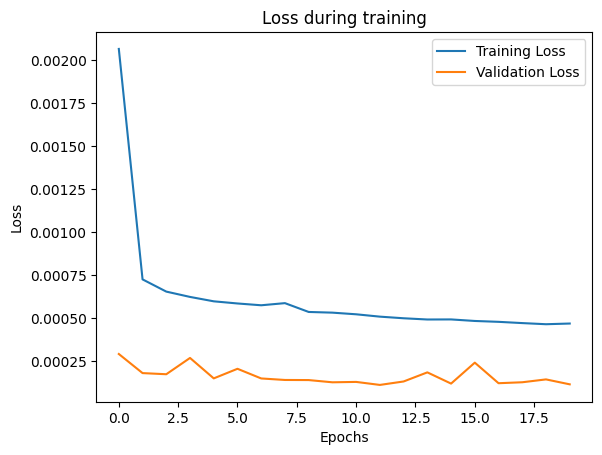

In [40]:
# Affichage de la courbe de perte pendant l'entraînement
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss during training')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [41]:
# Évaluation du modèle sur le jeu de test
test_loss = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 1.0761e-04 - mae: 0.0080
Test Loss: [0.00011430448648752645, 0.008174954913556576]


1407/1407 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step


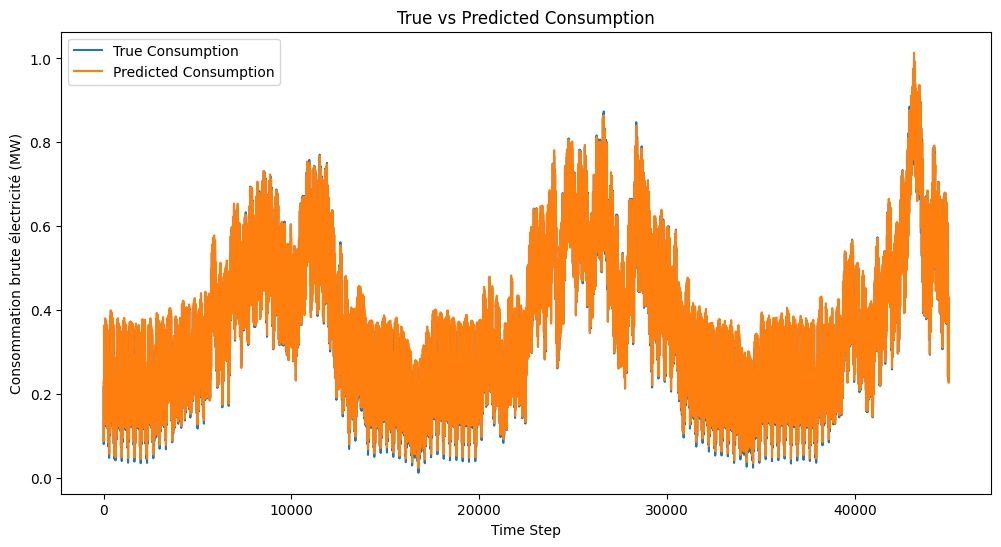

In [42]:
# Prédictions sur les données de test
y_pred = model.predict(X_test)

# Visualisation des résultats
plt.figure(figsize=(12, 6))
plt.plot(y_test, label='True Consumption')
plt.plot(y_pred, label='Predicted Consumption')
plt.title('True vs Predicted Consumption')
plt.xlabel('Time Step')
plt.ylabel('Consommation brute électricité (MW)')
plt.legend()
plt.show()
